<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/060922%20-%20LSTM_Future_Forecast_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [2]:
# download the data
df = yf.download(tickers=['^IXIC'], period='5y')
y = df['Close'].fillna(method='ffill').values.reshape(- 1, 1)

[*********************100%***********************]  1 of 1 completed


In [3]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [4]:
# generate the training sequences
n_forecast = 1 
n_lookback = 60

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [5]:
# train the model
tf.random.set_seed(0)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=128, validation_split=0.2, verbose=0)

In [6]:
# generate the multi-step forecasts
n_future = 365
y_future = []

x_pred = X[-1:, :, :]  # last observed input sequence
y_pred = Y[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

In [7]:
# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1, 1)
y_future = scaler.inverse_transform(y_future)

In [9]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Close', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future)
df_future['Forecast'] = y_future.flatten()
df_future['Close'] = np.nan

results = df_past.append(df_future).set_index('Date')


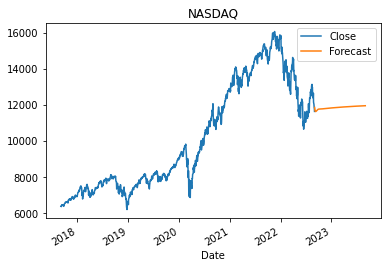

In [10]:
# plot the results
results.plot(title='NASDAQ')